## In the third, I try to identify skills for course curriculum design based on the Kaggle survey salary levels

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda_Python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [4]:
df_multipleChoice = pd.read_csv('E:\\KSE\\DS\\Course Project\\kagle\\_multipleChoiceResponses.csv', low_memory=False)

In [5]:
# getting questions
multipleChoice_q = pd.read_csv('E:\\KSE\\DS\\Course Project\\kagle\\multipleChoiceResponses.csv', low_memory=False, nrows=1)

# Data Cleaning and Data Preparation and  Exploratory Data Analysis

In [6]:
#getting compensation sample
_columns = [] 
_columnsnaim = [] 

def col_naim(i, naim_columns):
    q = multipleChoice_q[naim_columns + str(i)][0]
    f = q.rfind(' - ') + 3
    _columnsnaim.append(q[f:])

#list of columns for analysing
#list of names of columns
def col_for_salary(X, N):
    naim_columns = "Q" + str(X) + "_Part_" 
    for i in range(1,N):
        _columns.append(naim_columns + str(i))
        col_naim(i, naim_columns)
        
def col_to_bool(X, N):
    for i in range(1,N):
        df_comp["Q" + str(X) + "_Part_" + str(i)] = df_comp["Q" + 
                                                            str(X) + "_Part_" + 
                                                            str(i)].apply(lambda x: 0 if pd.isnull(x) else 1)
     

col_for_salary(13, 14) #IDEs Used
col_for_salary(14, 10) #NBs Used
col_for_salary(15, 7)  #Cloud Com. Ser. Used
col_for_salary(16, 17) #Prog. Languages Used
col_for_salary(19, 18) #ML Frameworks Used
col_for_salary(21, 12) #Visualization Libraries Used
col_for_salary(27, 19) #Cloud Computing products Used
col_for_salary(28, 42) #Cloud ML products Used
col_for_salary(29, 27) #RDBMS Used
col_for_salary(30, 24) #Big Data Products Used
col_for_salary(31, 12) #Type of Data used

_columns.append('Q1') #gender
_columns.append('Q3') #country
_columns.append('Q6') #Designation or Title
_columns.append('Q9') #What is your current yearly compensation (approximate $USD)?
_columns.append('Q12_MULTIPLE_CHOICE') #Primary tool used to analyze data
_columns.append('Q23') #Percent of time at work or school spent actively coding
_columns.append('Q24') #Years of writing code to analyze data
_columns.append('Q25') #Years of using machine learning methods

_columnsnaim.append('gender')
_columnsnaim.append('country')
_columnsnaim.append('title')
_columnsnaim.append('compensation')
_columnsnaim.append('tool')
_columnsnaim.append('% coding')
_columnsnaim.append('years coding')
_columnsnaim.append('ML using')

In [7]:
_columnsnaim

['Jupyter/IPython',
 'RStudio',
 'PyCharm',
 'Visual Studio Code',
 'nteract',
 'Atom',
 'MATLAB',
 'Visual Studio',
 'Notepad++',
 'Sublime Text',
 'Vim',
 'IntelliJ',
 'Spyder',
 'Kaggle Kernels',
 'Google Colab',
 'Azure Notebook',
 'Domino Datalab',
 'Google Cloud Datalab',
 'Paperspace',
 'Floydhub',
 'Crestle',
 'JupyterHub/Binder',
 'Google Cloud Platform (GCP)',
 'Amazon Web Services (AWS)',
 'Microsoft Azure',
 'IBM Cloud',
 'Alibaba Cloud',
 'I have not used any cloud providers',
 'Python',
 'R',
 'SQL',
 'Bash',
 'Java',
 'Javascript/Typescript',
 'Visual Basic/VBA',
 'C/C++',
 'MATLAB',
 'Scala',
 'Julia',
 'Go',
 'C#/.NET',
 'PHP',
 'Ruby',
 'SAS/STATA',
 'Scikit-Learn',
 'TensorFlow',
 'Keras',
 'PyTorch',
 'Spark MLlib',
 'H20',
 'Fastai',
 'Mxnet',
 'Caret',
 'Xgboost',
 'mlr',
 'Prophet',
 'randomForest',
 'lightgbm',
 'catboost',
 'CNTK',
 'Caffe',
 'ggplot2',
 'Matplotlib',
 'Altair',
 'Shiny',
 'D3',
 'Plotly',
 'Bokeh',
 'Seaborn',
 'Geoplotlib',
 'Leaflet',
 'Latt

In [8]:
# dropping all NaN and I do not wish to disclose my approximate yearly compensation, 
#because we are only interested in respondents that revealed their earnings
df_comp = df_multipleChoice[~df_multipleChoice.Q9.isnull()].copy()

# removing student trolls, because a student won't make more than 250k a year.
student_trolls = df_comp[((df_comp.Q6 == 'Student') & (df_comp.Q9 > '500,000+')) | \
                     ((df_comp.Q6 == 'Student') & (df_comp.Q9 > '400-500,000')) | \
                     ((df_comp.Q6 == 'Student') & (df_comp.Q9 > '300-400,000')) | \
                     ((df_comp.Q6 == 'Student') & (df_comp.Q9 > '250-300,000'))].index
df_comp = df_comp.drop(list(student_trolls), axis=0)

df_comp = df_comp[_columns]
# cleanup salary data
df_comp = df_comp[~df_comp.Q9.isin(['I do not wish to disclose my approximate yearly compensation','500,000+'])]
df_comp = df_comp[~df_comp.Q3.isin(['I do not wish to disclose my location'])]
df_comp = df_comp[~df_comp.Q24.isin(['I have never written code and I do not want to learn','I have never written code but I want to learn'])]
df_comp = df_comp[~df_comp.Q25.isin(['I have never studied machine learning and I do not plan to','I have never studied machine learning but plan to learn in the future'])] 

In [9]:
import re
# represent compensation with range midpoint
def extract_avg_pay(compensation):
    result = re.split('-|,',compensation)
    return 1000*(int(result[0]) + int(result[1]))/2

In [10]:
df_comp['comp'] = df_comp['Q9'].apply(extract_avg_pay)

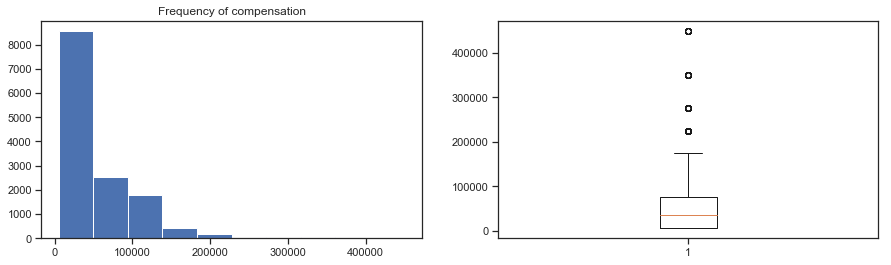

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title('Frequency of compensation')
ax[0].hist(df_comp['comp'], bins=10)
ax[1].boxplot(df_comp['comp'])
plt.show()

In [12]:
df_comp.groupby('Q1')['Q1'].count()

Q1
Female                      2017
Male                       11450
Prefer not to say             94
Prefer to self-describe       44
Name: Q1, dtype: int64

In [13]:
df_comp = df_comp[~df_comp.Q1.isin(['Prefer not to say','Prefer to self-describe'])] 

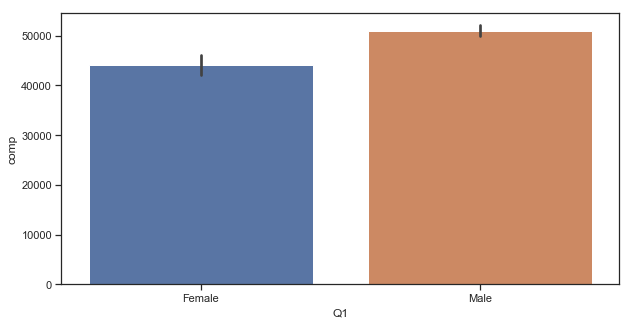

In [14]:
rcParams['figure.figsize'] = 10,5
sns.barplot(x='Q1',y='comp',data=df_comp)

In [15]:
df_comp.groupby('Q1')['comp'].max()

Q1
Female    350000.0
Male      450000.0
Name: comp, dtype: float64

In [16]:
df_comp['Q3'].value_counts().index.values

array(['United States of America', 'India', 'China', 'Other', 'Russia',
       'Brazil', 'Germany',
       'United Kingdom of Great Britain and Northern Ireland', 'Canada',
       'France', 'Japan', 'Spain', 'Italy', 'Australia', 'Poland',
       'Turkey', 'Netherlands', 'Ukraine', 'Mexico', 'Israel',
       'Singapore', 'Sweden', 'South Korea', 'South Africa',
       'Switzerland', 'Nigeria', 'Portugal', 'Viet Nam', 'Colombia',
       'Argentina', 'Indonesia', 'Pakistan', 'Greece', 'Denmark',
       'Belgium', 'Ireland', 'Malaysia', 'Hungary', 'Belarus', 'Chile',
       'Iran, Islamic Republic of...', 'Egypt', 'New Zealand', 'Romania',
       'Bangladesh', 'Norway', 'Finland', 'Peru', 'Republic of Korea',
       'Thailand', 'Czech Republic', 'Austria', 'Kenya',
       'Hong Kong (S.A.R.)', 'Philippines', 'Tunisia', 'Morocco'],
      dtype=object)

In [17]:
df_comp.Q3 = df_comp.Q3.str.replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
df_comp.Q3 = df_comp.Q3.str.replace('United States of America', 'United States')
df_comp.Q3 = df_comp.Q3.str.replace('I do not wish to disclose my location', 'Not Disclosed')
df_comp.Q3 = df_comp.Q3.str.replace('Iran, Islamic Republic of...', 'Iran')
df_comp.Q3 = df_comp.Q3.str.replace('Hong Kong \(S.A.R.\)', 'Hong Kong')
df_comp.Q3 = df_comp.Q3.str.replace('Viet Nam', 'Vietnam')
df_comp.Q3 = df_comp.Q3.str.replace('Republic of Korea', 'South Korea')


In [18]:
country_max = df_comp.groupby('Q3')['comp'].max().reset_index()
country_max = country_max.sort_values(['comp','Q3'], ascending=False)
country_max

,Q3,comp
54,United States,450000.0
48,Switzerland,450000.0
44,South Africa,450000.0
42,Russia,450000.0
26,Japan,450000.0
25,Italy,450000.0
20,India,450000.0
9,China,450000.0
7,Canada,450000.0
53,United Kingdom,350000.0


In [19]:
country_count = df_comp.groupby('Q3')['Q3'].count()
country_count

Q3
Argentina           83
Australia          201
Austria             39
Bangladesh          47
Belarus             55
Belgium             71
Brazil             502
Canada             392
Chile               52
China              809
Colombia            83
Czech Republic      42
Denmark             74
Egypt               49
Finland             47
France             391
Germany            458
Greece              77
Hong Kong           35
Hungary             62
India             2007
Indonesia           79
Iran                49
Ireland             65
Israel             115
Italy              216
Japan              386
Kenya               39
Malaysia            63
Mexico             128
Morocco             26
Netherlands        170
New Zealand         49
Nigeria            100
Norway              47
Other              574
Pakistan            77
Peru                46
Philippines         34
Poland             196
Portugal            95
Romania             48
Russia             533
Singapor

In [20]:
country_ = df_comp.groupby('Q3')['comp'].mean().reset_index()
country_ = country_.sort_values(['comp','Q3'], ascending=False)

In [21]:
country_

,Q3,comp
48,Switzerland,102378.640777
54,United States,99142.661180
24,Israel,86891.304348
1,Australia,85845.771144
12,Denmark,70844.594595
34,Norway,70691.489362
7,Canada,68801.020408
18,Hong Kong,66285.714286
53,United Kingdom,65698.198198
23,Ireland,60615.384615


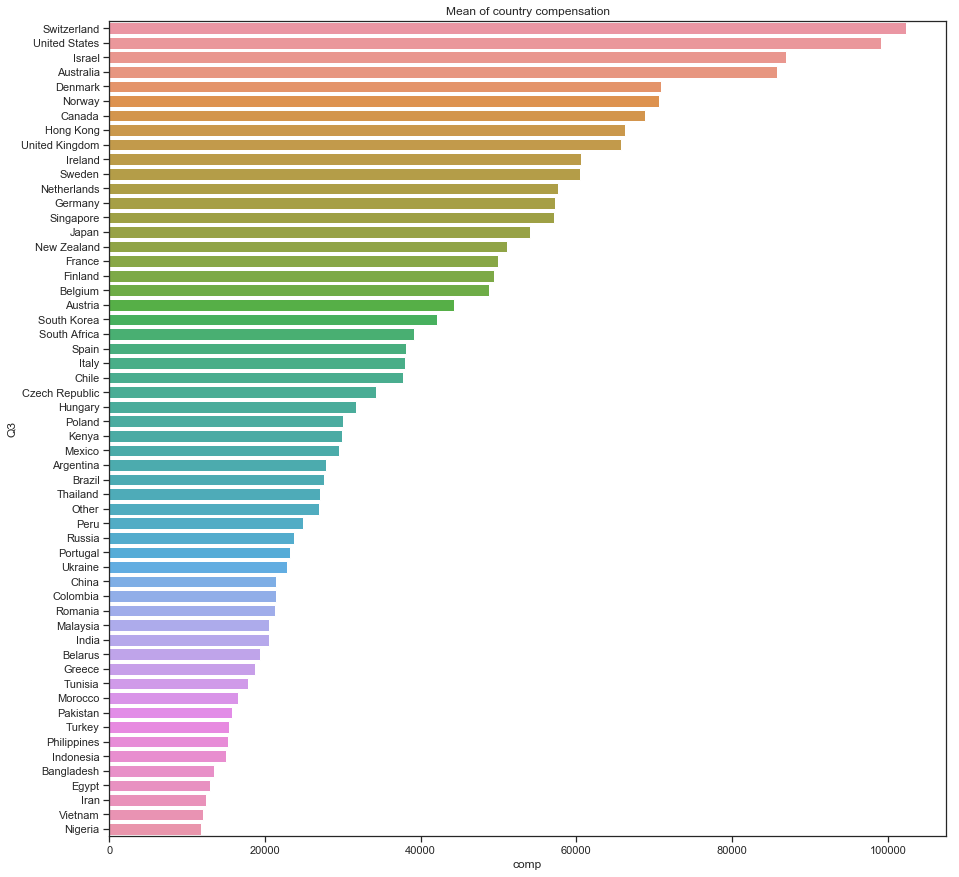

In [22]:
plt.figure(figsize=(15,15))
plt.title('Mean of country compensation')
sns.barplot(y='Q3',x='comp',data=country_)

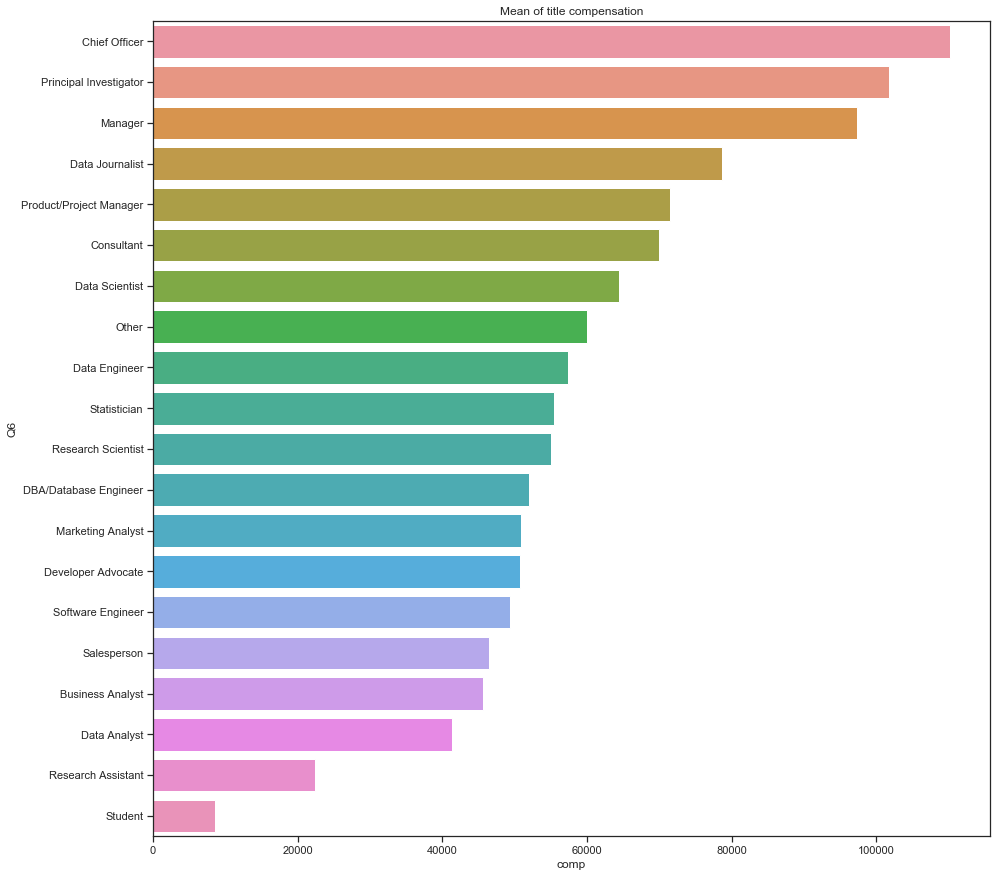

In [23]:
title_ = df_comp.groupby('Q6')['comp'].mean().reset_index()
title_ = title_.sort_values(['comp','Q6'], ascending=False)
plt.figure(figsize=(15,15))
plt.title('Mean of title compensation')
sns.barplot(y='Q6',x='comp',data=title_)

In [24]:
title_ = df_comp.groupby('Q6')['Q6'].count().reset_index(name='count').sort_values(['count'], ascending=False)
title_ 

,Q6,count
7,Data Scientist,3154
19,Student,2139
17,Software Engineer,2031
4,Data Analyst,1234
15,Research Scientist,855
11,Other,786
5,Data Engineer,525
2,Consultant,494
0,Business Analyst,469
14,Research Assistant,398


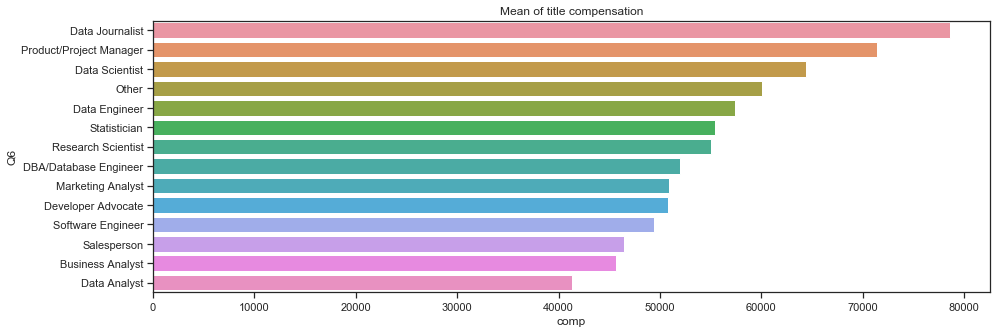

In [25]:
title_ = df_comp[(df_comp['Q6'] != 'Chief Officer')&(df_comp['Q6'] != 'Manager')&(df_comp['Q6'] != 'Student')
                                    &(df_comp['Q6'] != 'Principal Investigator')
                                    &(df_comp['Q6'] != 'Research Assistant')
                                    &(df_comp['Q6'] != 'Consultant')].groupby('Q6')['comp'].mean().reset_index()
title_ = title_.sort_values(['comp','Q6'], ascending=False)
plt.figure(figsize=(15,5))
plt.title('Mean of title compensation')
sns.barplot(y='Q6',x='comp',data=title_)

In [26]:
df_comp = df_comp[(df_comp['Q6'] != 'Chief Officer')&(df_comp['Q6'] != 'Manager')&(df_comp['Q6'] != 'Student')
                                    &(df_comp['Q6'] != 'Principal Investigator')&(df_comp['Q6'] != 'Research Assistant')
                                    &(df_comp['Q6'] != 'Consultant')]

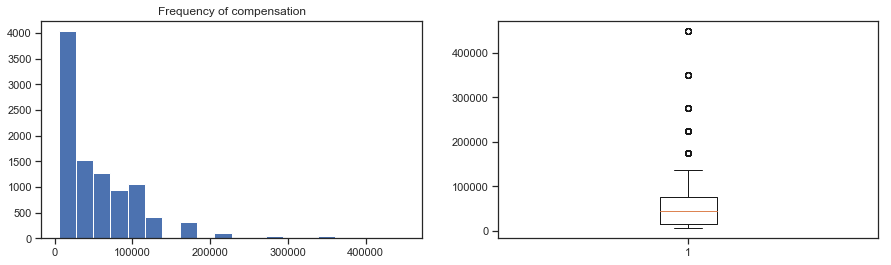

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title('Frequency of compensation')
ax[0].hist(df_comp['comp'], bins=20)
ax[1].boxplot(df_comp['comp'])
plt.show()

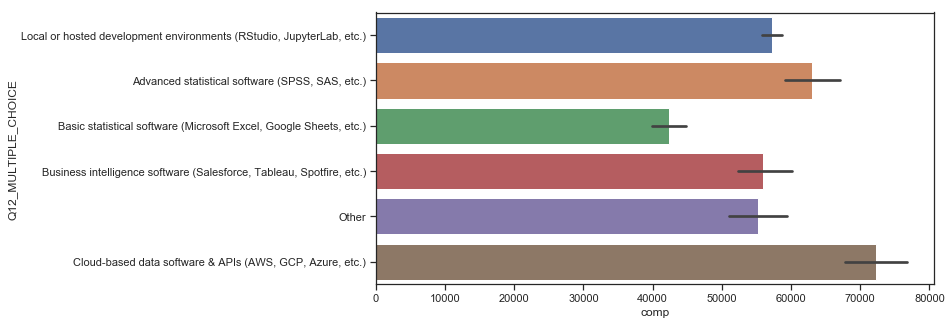

In [28]:
rcParams['figure.figsize'] = 10,5
sns.barplot(y='Q12_MULTIPLE_CHOICE',x='comp',data=df_comp)

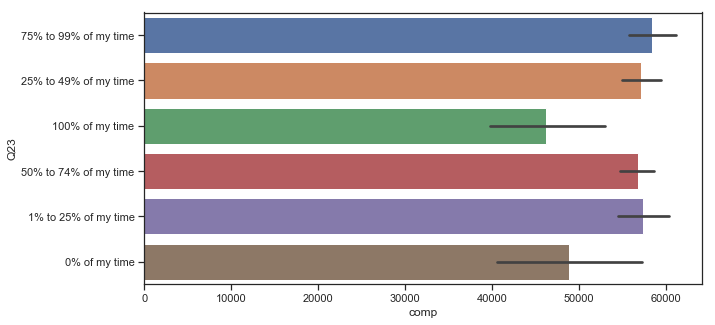

In [29]:
sns.barplot(y='Q23',x='comp',data=df_comp)

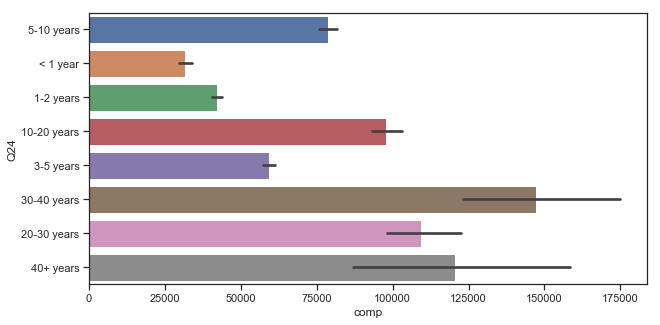

In [30]:
sns.barplot(y='Q24',x='comp',data=df_comp)

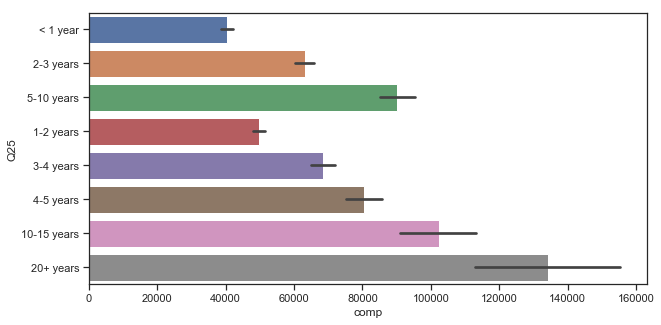

In [31]:
sns.barplot(y='Q25',x='comp',data=df_comp)

In [32]:
#to do features to boolean
col_to_bool(13, 14)
col_to_bool(14, 10) 
col_to_bool(15, 7)  
col_to_bool(16, 17) 
col_to_bool(19, 18) 
col_to_bool(21, 12) 
col_to_bool(27, 19) 
col_to_bool(28, 42) 
col_to_bool(29, 27) 
col_to_bool(30, 24) 
col_to_bool(31, 12)
df_comp['Q1'] = df_comp['Q1'].apply(lambda x: 0 if x == 'Female' else 1)

#I exclude question number 4 "Highest Education attained or planned" cause there is an inaccurate reply 

In [33]:
df_comp['Q23'].value_counts().index.values

array(['50% to 74% of my time', '25% to 49% of my time',
       '75% to 99% of my time', '1% to 25% of my time', '100% of my time',
       '0% of my time'], dtype=object)

In [34]:
df_comp.Q23 = df_comp.Q23.str.replace(' to ','-')
df_comp.Q23 = df_comp.Q23.str.replace(' of my time','')

In [35]:
df_comp['Q24'].value_counts().index.values

array(['1-2 years', '3-5 years', '< 1 year', '5-10 years', '10-20 years',
       '20-30 years', '30-40 years', '40+ years'], dtype=object)

In [36]:
df_comp.Q24 = df_comp.Q24.str.replace(' years','')

In [37]:
df_comp.Q25 = df_comp.Q25.str.replace(' years','')

In [38]:
df_comp.columns

Index(['Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_5',
       'Q13_Part_6', 'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q13_Part_10',
       ...
       'Q31_Part_11', 'Q1', 'Q3', 'Q6', 'Q9', 'Q12_MULTIPLE_CHOICE', 'Q23',
       'Q24', 'Q25', 'comp'],
      dtype='object', length=200)

In [39]:
len(_columnsnaim)

199

In [40]:
columnsnaim=df_comp.columns
ren_col = dict(zip(columnsnaim,_columnsnaim))

In [41]:
ren_col

{'Q13_Part_1': 'Jupyter/IPython',
 'Q13_Part_2': 'RStudio',
 'Q13_Part_3': 'PyCharm',
 'Q13_Part_4': 'Visual Studio Code',
 'Q13_Part_5': 'nteract',
 'Q13_Part_6': 'Atom',
 'Q13_Part_7': 'MATLAB',
 'Q13_Part_8': 'Visual Studio',
 'Q13_Part_9': 'Notepad++',
 'Q13_Part_10': 'Sublime Text',
 'Q13_Part_11': 'Vim',
 'Q13_Part_12': 'IntelliJ',
 'Q13_Part_13': 'Spyder',
 'Q14_Part_1': 'Kaggle Kernels',
 'Q14_Part_2': 'Google Colab',
 'Q14_Part_3': 'Azure Notebook',
 'Q14_Part_4': 'Domino Datalab',
 'Q14_Part_5': 'Google Cloud Datalab',
 'Q14_Part_6': 'Paperspace',
 'Q14_Part_7': 'Floydhub',
 'Q14_Part_8': 'Crestle',
 'Q14_Part_9': 'JupyterHub/Binder',
 'Q15_Part_1': 'Google Cloud Platform (GCP)',
 'Q15_Part_2': 'Amazon Web Services (AWS)',
 'Q15_Part_3': 'Microsoft Azure',
 'Q15_Part_4': 'IBM Cloud',
 'Q15_Part_5': 'Alibaba Cloud',
 'Q15_Part_6': 'I have not used any cloud providers',
 'Q16_Part_1': 'Python',
 'Q16_Part_2': 'R',
 'Q16_Part_3': 'SQL',
 'Q16_Part_4': 'Bash',
 'Q16_Part_5': 'Jav

In [42]:
df_comp.rename(columns=ren_col, inplace=True)

In [43]:
del ren_col['Q9']
df_comp.drop(['compensation'], axis=1, inplace=True)
del ren_col['Q15_Part_6']
df_comp.drop(['I have not used any cloud providers'], axis=1, inplace=True)

In [44]:
df_comp = pd.get_dummies(df_comp, columns = ['country','title','tool','% coding','years coding','ML using'], prefix_sep='<>', drop_first=False)

In [45]:
df_comp.iloc[:,0:13].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 13 columns):
Jupyter/IPython       9774 non-null int64
RStudio               9774 non-null int64
PyCharm               9774 non-null int64
Visual Studio Code    9774 non-null int64
nteract               9774 non-null int64
Atom                  9774 non-null int64
MATLAB                9774 non-null int64
Visual Studio         9774 non-null int64
Notepad++             9774 non-null int64
Sublime Text          9774 non-null int64
Vim                   9774 non-null int64
IntelliJ              9774 non-null int64
Spyder                9774 non-null int64
dtypes: int64(13)
memory usage: 1.0 MB


In [46]:
df_comp.iloc[:,0:13].describe(include='all')

,Jupyter/IPython,RStudio,PyCharm,Visual Studio Code,nteract,Atom,MATLAB,Visual Studio,Notepad++,Sublime Text,Vim,IntelliJ,Spyder
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.00000
mean,0.712400,0.449867,0.364232,0.251484,0.007264,0.191938,0.235011,0.231533,0.384285,0.300389,0.224166,0.175056,0.26151
std,0.452667,0.497506,0.481239,0.433888,0.084924,0.393845,0.424028,0.421833,0.486451,0.458451,0.417053,0.380035,0.43948
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [47]:
def get_corr(n1, n2):
    newdf = df_comp.iloc[:,n1:n2]
    newdf = pd.concat([newdf, df_comp['comp']], axis=1)
    mask = np.zeros_like(newdf.corr()*-1)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(newdf.corr(), mask=mask, annot=True)

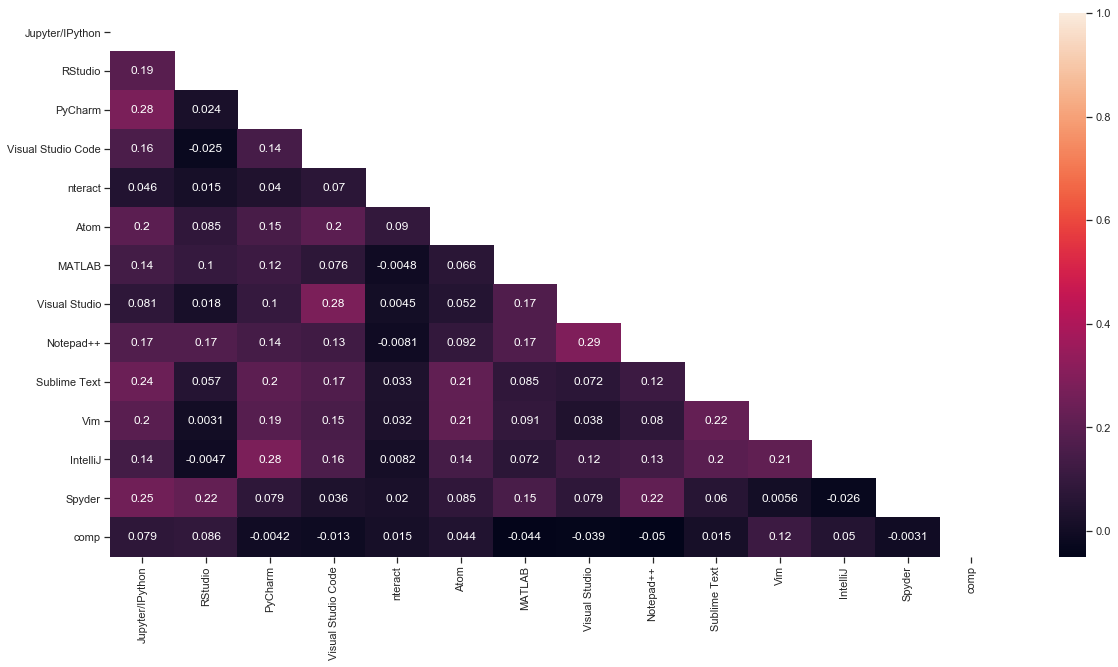

In [48]:
rcParams['figure.figsize'] = 20,10
get_corr(0, 13)

In [49]:
df_comp.iloc[:,13:22].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 9 columns):
Kaggle Kernels          9774 non-null int64
Google Colab            9774 non-null int64
Azure Notebook          9774 non-null int64
Domino Datalab          9774 non-null int64
Google Cloud Datalab    9774 non-null int64
Paperspace              9774 non-null int64
Floydhub                9774 non-null int64
Crestle                 9774 non-null int64
JupyterHub/Binder       9774 non-null int64
dtypes: int64(9)
memory usage: 763.6 KB


In [50]:
df_comp.iloc[:,13:22].describe(include='all')

,Kaggle Kernels,Google Colab,Azure Notebook,Domino Datalab,Google Cloud Datalab,Paperspace,Floydhub,Crestle,JupyterHub/Binder
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000
mean,0.304686,0.177716,0.068652,0.007571,0.068242,0.027522,0.019030,0.007060,0.246982
std,0.460298,0.382293,0.252874,0.086687,0.252174,0.163607,0.136638,0.083728,0.431278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


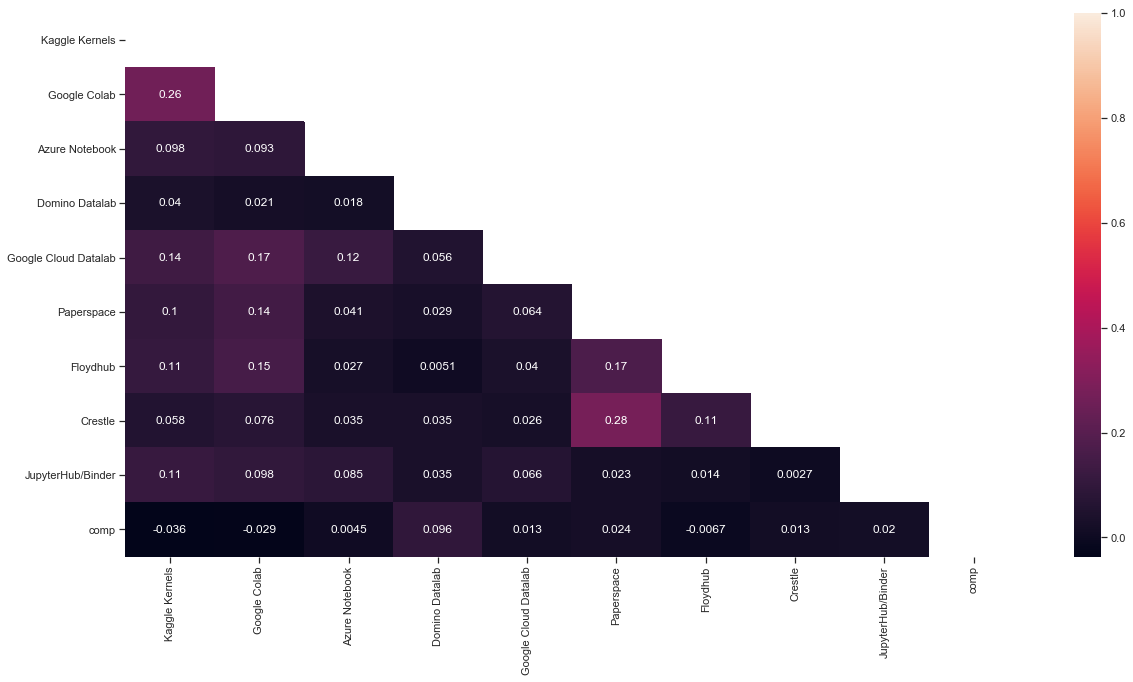

In [51]:
get_corr(13, 22)

In [52]:
df_comp.iloc[:,22:27].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 5 columns):
Google Cloud Platform (GCP)    9774 non-null int64
Amazon Web Services (AWS)      9774 non-null int64
Microsoft Azure                9774 non-null int64
IBM Cloud                      9774 non-null int64
Alibaba Cloud                  9774 non-null int64
dtypes: int64(5)
memory usage: 458.2 KB


In [53]:
df_comp.iloc[:,22:27].describe(include='all')

,Google Cloud Platform (GCP),Amazon Web Services (AWS),Microsoft Azure,IBM Cloud,Alibaba Cloud
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000
mean,0.256292,0.439022,0.211377,0.060773,0.021281
std,0.436607,0.496293,0.408306,0.238927,0.144327
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


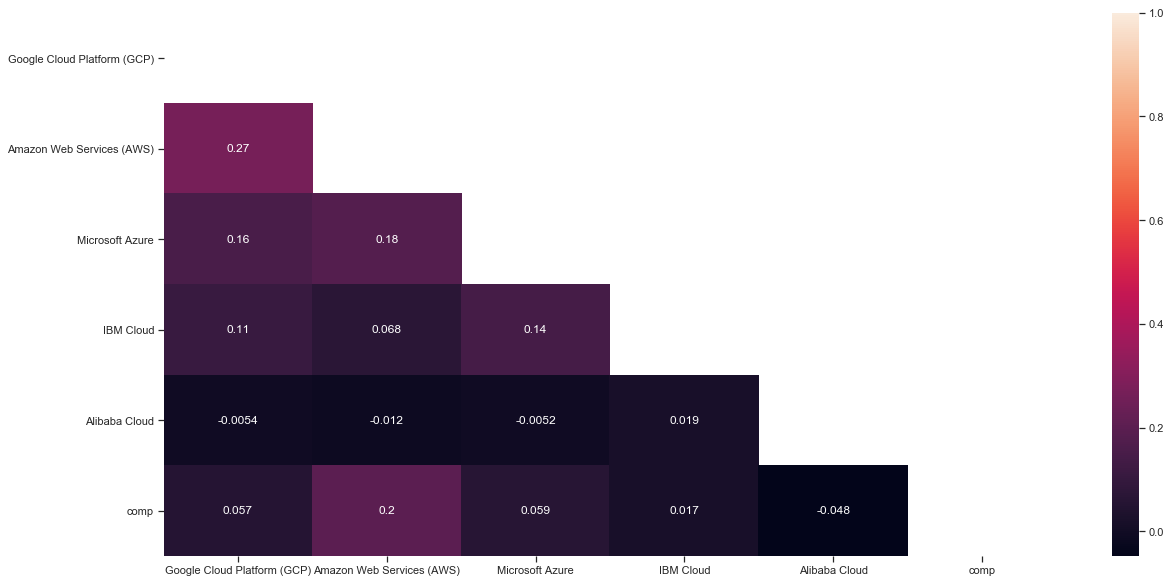

In [54]:
get_corr(22, 27)

In [55]:
df_comp.iloc[:,27:43].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 16 columns):
Python                   9774 non-null int64
R                        9774 non-null int64
SQL                      9774 non-null int64
Bash                     9774 non-null int64
Java                     9774 non-null int64
Javascript/Typescript    9774 non-null int64
Visual Basic/VBA         9774 non-null int64
C/C++                    9774 non-null int64
MATLAB                   9774 non-null int64
Scala                    9774 non-null int64
Julia                    9774 non-null int64
Go                       9774 non-null int64
C#/.NET                  9774 non-null int64
PHP                      9774 non-null int64
Ruby                     9774 non-null int64
SAS/STATA                9774 non-null int64
dtypes: int64(16)
memory usage: 1.3 MB


In [56]:
df_comp.iloc[:,27:43].describe(include='all')

,Python,R,SQL,Bash,Java,Javascript/Typescript,Visual Basic/VBA,C/C++,MATLAB,Scala,Julia,Go,C#/.NET,PHP,Ruby,SAS/STATA
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.00000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.00000,9774.000000,9774.000000,9774.000000
mean,0.774504,0.352159,0.454778,0.159198,0.16769,0.162267,0.060569,0.155617,0.093718,0.053714,0.010743,0.021895,0.08052,0.050338,0.016984,0.055556
std,0.417930,0.477668,0.497976,0.365879,0.37361,0.368715,0.238550,0.362510,0.291451,0.225464,0.103094,0.146348,0.27211,0.218652,0.129217,0.229073
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


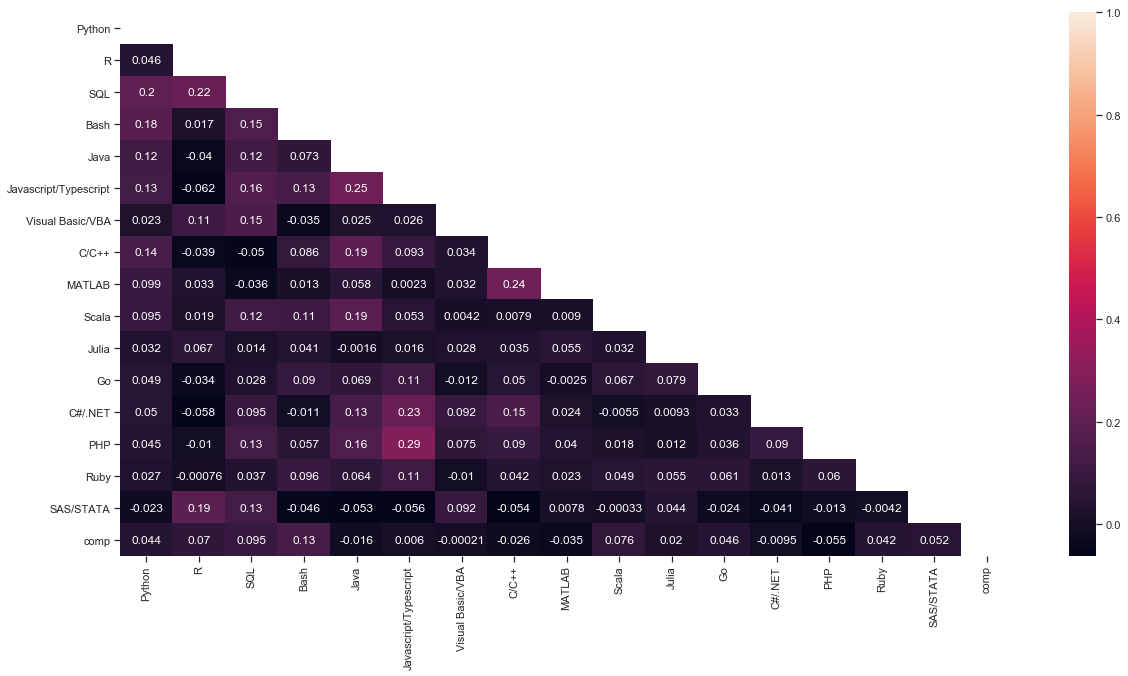

In [57]:
rcParams['figure.figsize'] = 20,10
get_corr(27, 43)

In [58]:
df_comp.iloc[:,43:60].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 17 columns):
Scikit-Learn    9774 non-null int64
TensorFlow      9774 non-null int64
Keras           9774 non-null int64
PyTorch         9774 non-null int64
Spark MLlib     9774 non-null int64
H20             9774 non-null int64
Fastai          9774 non-null int64
Mxnet           9774 non-null int64
Caret           9774 non-null int64
Xgboost         9774 non-null int64
mlr             9774 non-null int64
Prophet         9774 non-null int64
randomForest    9774 non-null int64
lightgbm        9774 non-null int64
catboost        9774 non-null int64
CNTK            9774 non-null int64
Caffe           9774 non-null int64
dtypes: int64(17)
memory usage: 1.3 MB


In [59]:
df_comp.iloc[:,43:60].describe(include='all')

,Scikit-Learn,TensorFlow,Keras,PyTorch,Spark MLlib,H20,Fastai,Mxnet,Caret,Xgboost,mlr,Prophet,randomForest,lightgbm,catboost,CNTK,Caffe
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000
mean,0.663597,0.519951,0.443933,0.198895,0.139554,0.088091,0.065173,0.037139,0.148762,0.344178,0.033865,0.051565,0.345508,0.130755,0.065480,0.043892,0.056476
std,0.472503,0.499627,0.496872,0.399189,0.346541,0.283441,0.246843,0.189113,0.355872,0.475124,0.180892,0.221159,0.475558,0.337150,0.247383,0.204865,0.230851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


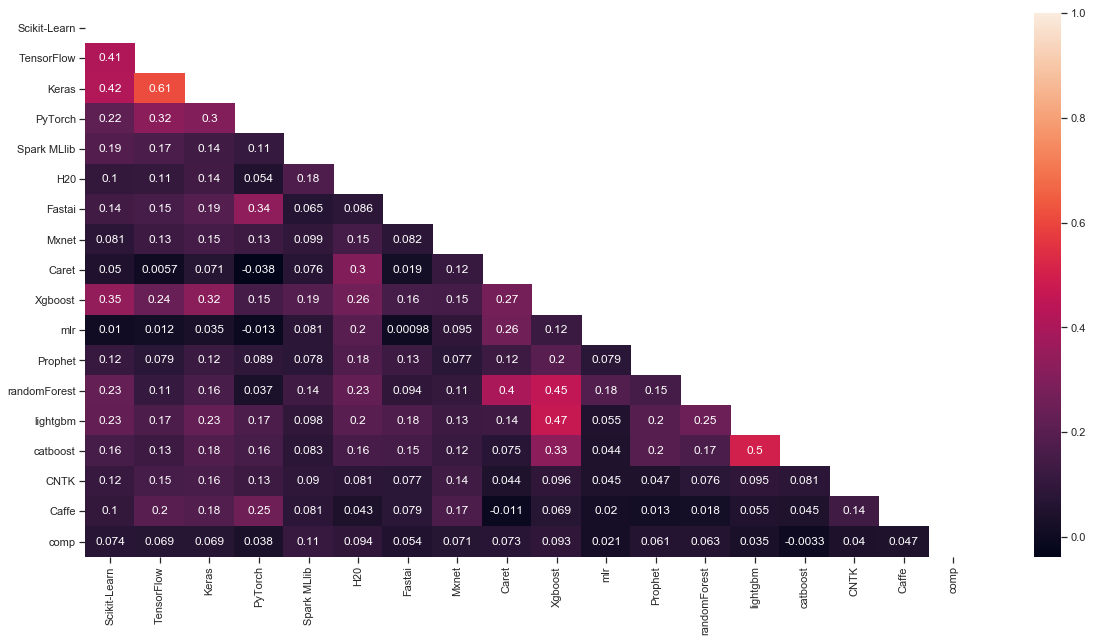

In [60]:
get_corr(43, 60)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 11 columns):
ggplot2       9774 non-null int64
Matplotlib    9774 non-null int64
Altair        9774 non-null int64
Shiny         9774 non-null int64
D3            9774 non-null int64
Plotly        9774 non-null int64
Bokeh         9774 non-null int64
Seaborn       9774 non-null int64
Geoplotlib    9774 non-null int64
Leaflet       9774 non-null int64
Lattice       9774 non-null int64
dtypes: int64(11)
memory usage: 916.3 KB


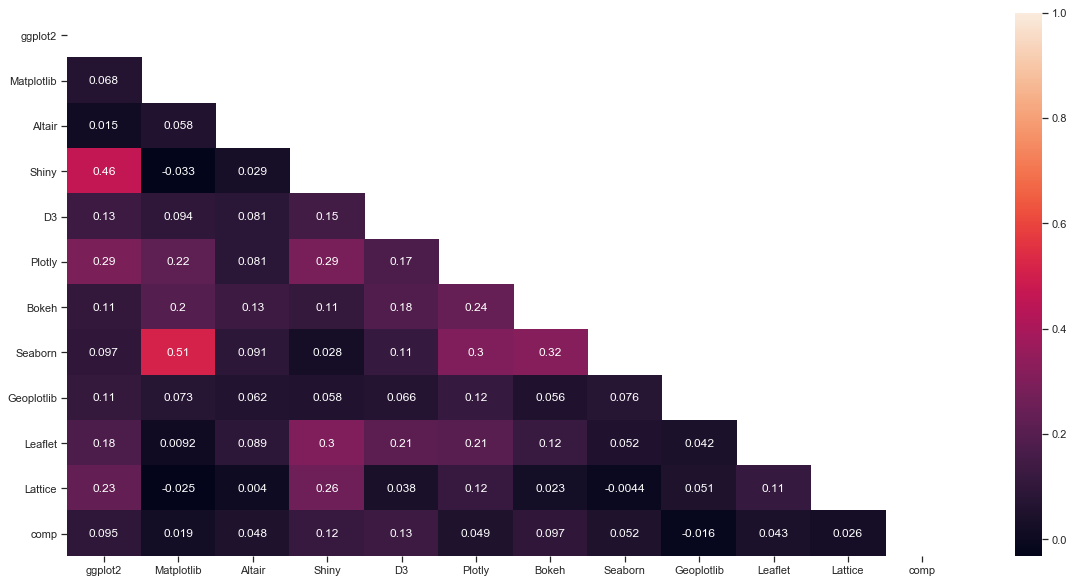

In [61]:
df_comp.iloc[:,60:71].info()
df_comp.iloc[:,60:71].describe(include='all')
get_corr(60, 71)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 18 columns):
AWS Elastic Compute Cloud (EC2)    9774 non-null int64
Google Compute Engine              9774 non-null int64
AWS Elastic Beanstalk              9774 non-null int64
Google App Engine                  9774 non-null int64
Google Kubernetes Engine           9774 non-null int64
AWS Lambda                         9774 non-null int64
Google Cloud Functions             9774 non-null int64
AWS Batch                          9774 non-null int64
Azure Virtual Machines             9774 non-null int64
Azure Container Service            9774 non-null int64
Azure Functions                    9774 non-null int64
Azure Event Grid                   9774 non-null int64
Azure Batch                        9774 non-null int64
Azure Kubernetes Service           9774 non-null int64
IBM Cloud Virtual Servers          9774 non-null int64
IBM Cloud Container Registry       9774 non-null int64
IBM Cloud Ku

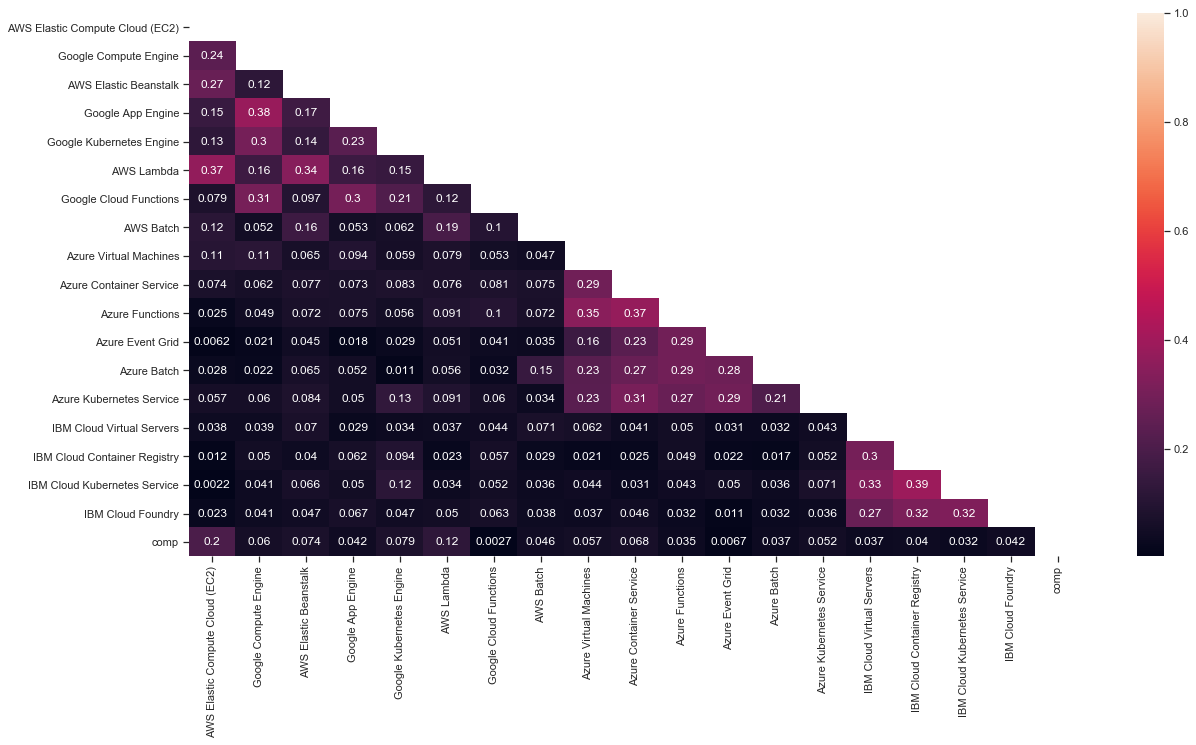

In [62]:
df_comp.iloc[:,71:89].info()
df_comp.iloc[:,71:89].describe(include='all')
get_corr(71, 89)

In [63]:
df_comp.iloc[:,89:130].info()
df_comp.iloc[:,89:130].describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 41 columns):
Amazon Transcribe                       9774 non-null int64
Google Cloud Speech-to-text API         9774 non-null int64
Amazon Rekognition                      9774 non-null int64
Google Cloud Vision API                 9774 non-null int64
Amazon Comprehend                       9774 non-null int64
Google Cloud Natural Language API       9774 non-null int64
Amazon Translate                        9774 non-null int64
Google Cloud Translation API            9774 non-null int64
Amazon Lex                              9774 non-null int64
Google Dialogflow Enterprise Edition    9774 non-null int64
Amazon Rekognition Video                9774 non-null int64
Google Cloud Video Intelligence API     9774 non-null int64
Google Cloud AutoML                     9774 non-null int64
Amazon SageMaker                        9774 non-null int64
Google Cloud Machine Learning Engine    9774 non-nul

,Amazon Transcribe,Google Cloud Speech-to-text API,Amazon Rekognition,Google Cloud Vision API,Amazon Comprehend,Google Cloud Natural Language API,Amazon Translate,Google Cloud Translation API,Amazon Lex,Google Dialogflow Enterprise Edition,...,Azure Face API,Azure Video API,IBM Watson Studio,IBM Watson Knowledge Catalog,IBM Watson Assistant,IBM Watson Discovery,IBM Watson Text to Speech,IBM Watson Visual Recognition,IBM Watson Machine Learning,Azure Cognitive Services
count,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,...,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000,9774.000000
mean,0.006548,0.033661,0.018928,0.039493,0.008901,0.037139,0.008697,0.029466,0.012891,0.010027,...,0.011254,0.004706,0.025783,0.010538,0.017188,0.014017,0.017291,0.010845,0.028545,0.019439
std,0.080658,0.180364,0.136277,0.194774,0.093930,0.189113,0.092854,0.169117,0.112812,0.099635,...,0.105493,0.068445,0.158495,0.102118,0.129980,0.117566,0.130359,0.103579,0.166533,0.138070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


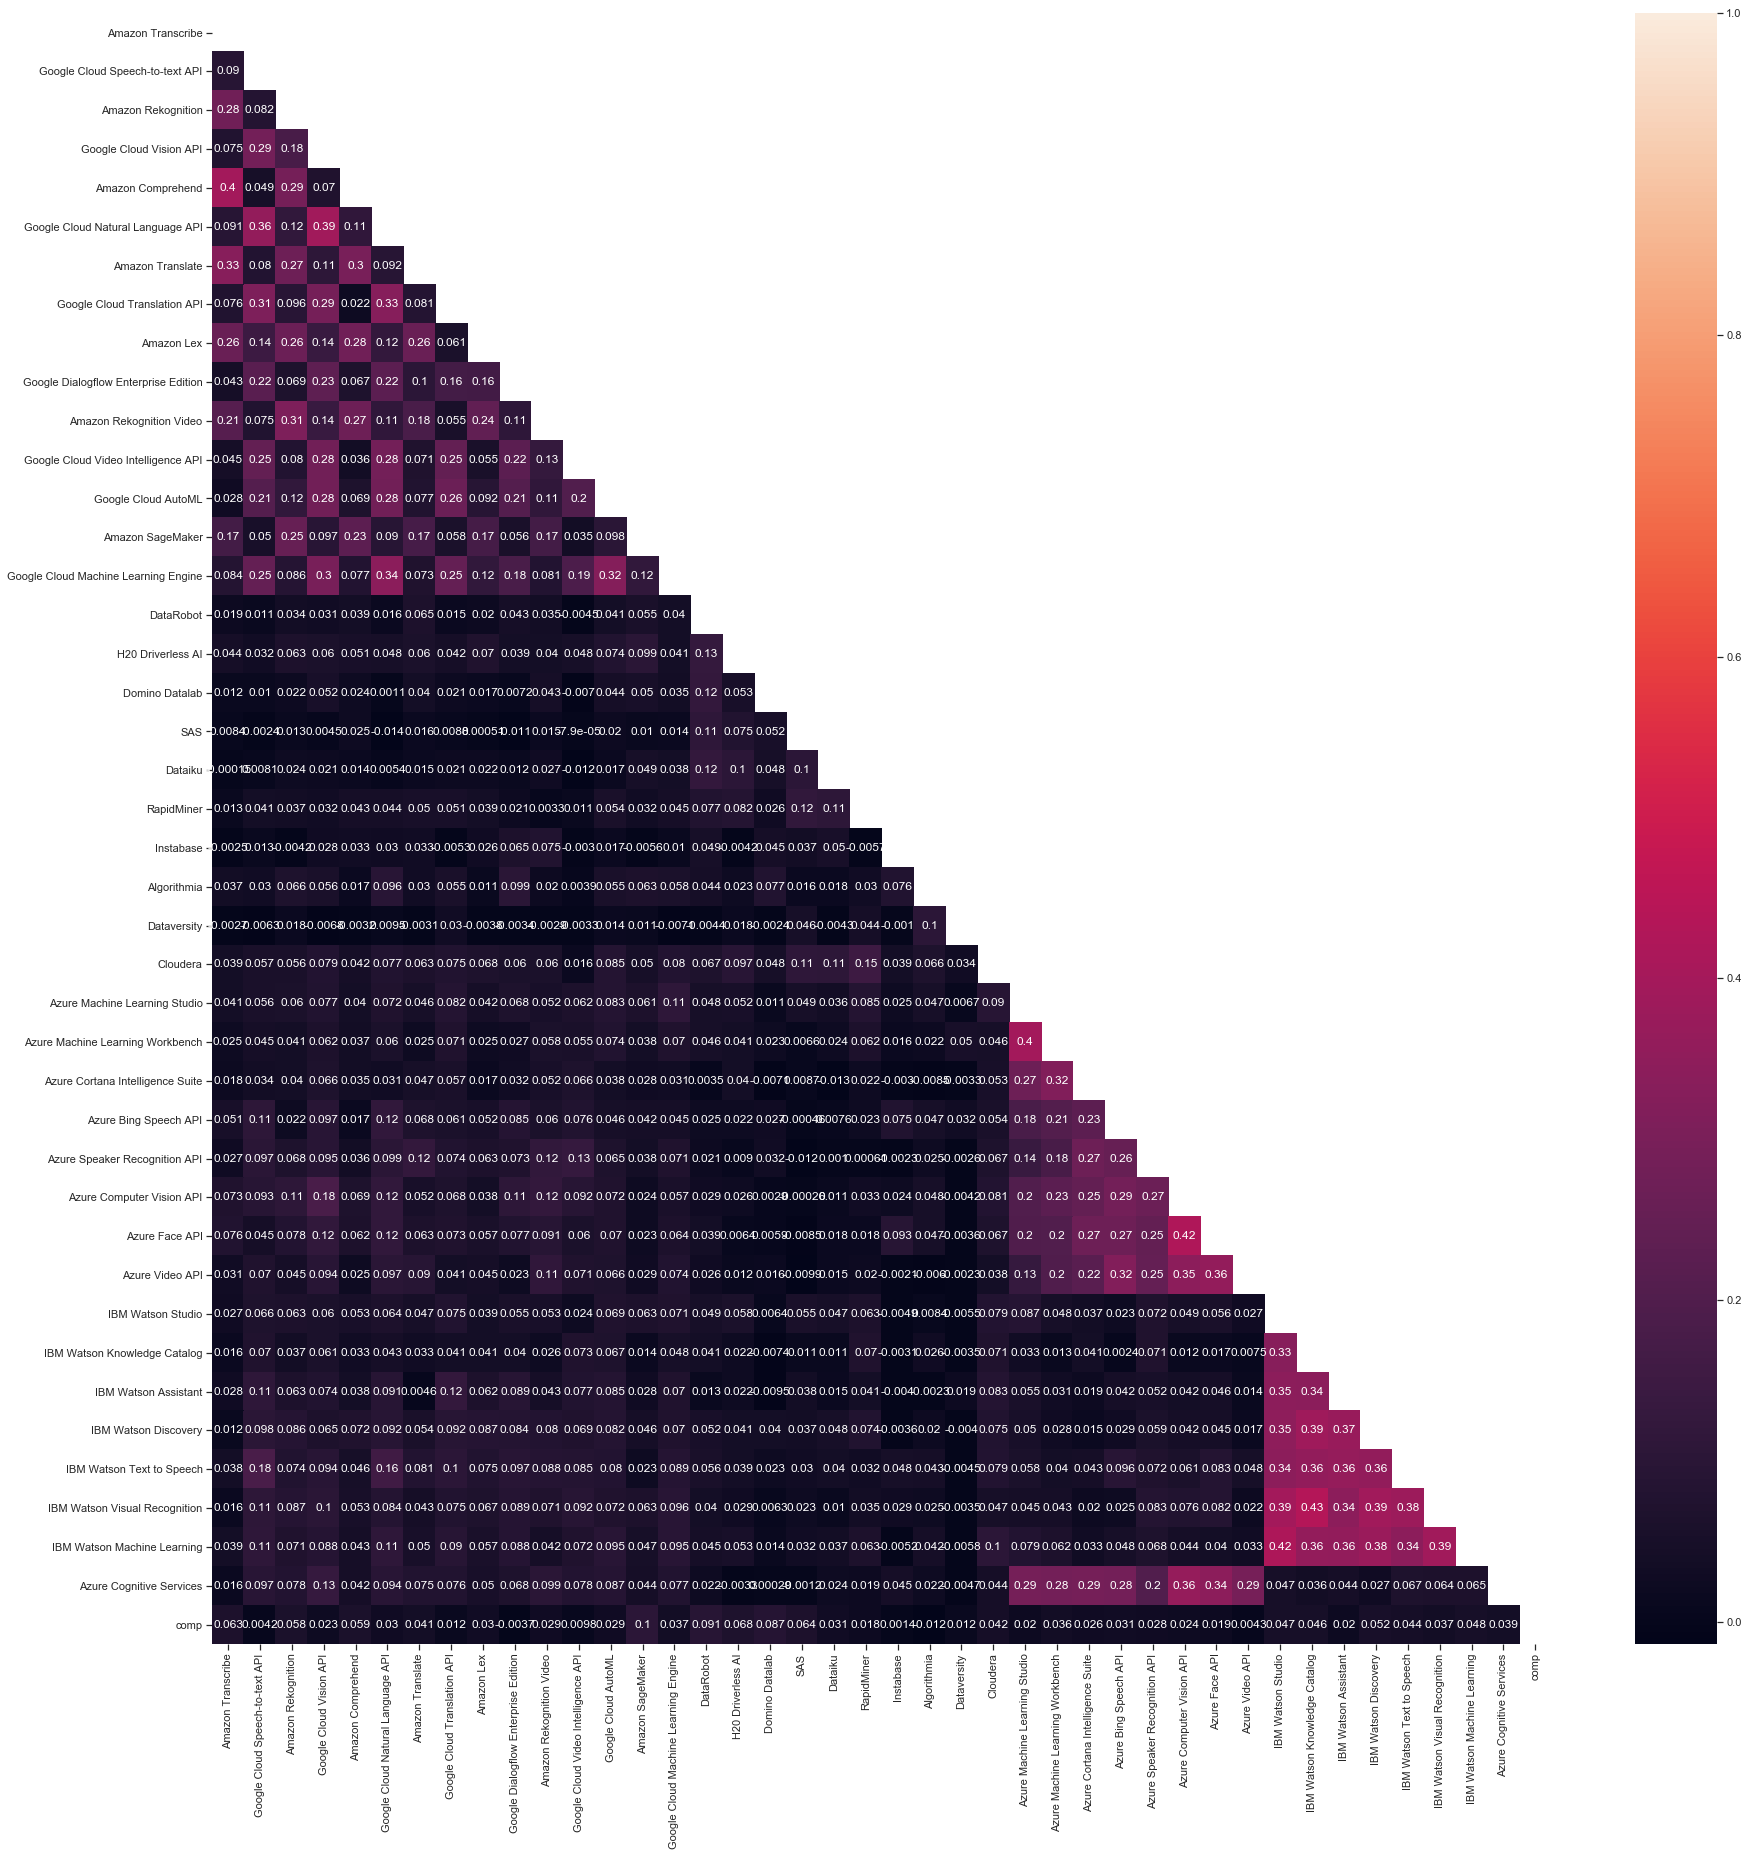

In [64]:
rcParams['figure.figsize'] = 30,30
get_corr(89, 130)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 26 columns):
AWS Relational Database Service     9774 non-null int64
AWS Aurora                          9774 non-null int64
Google Cloud SQL                    9774 non-null int64
Google Cloud Spanner                9774 non-null int64
AWS DynamoDB                        9774 non-null int64
Google Cloud Datastore              9774 non-null int64
Google Cloud Bigtable               9774 non-null int64
AWS SimpleDB                        9774 non-null int64
Microsoft SQL Server                9774 non-null int64
MySQL                               9774 non-null int64
PostgresSQL                         9774 non-null int64
SQLite                              9774 non-null int64
Oracle Database                     9774 non-null int64
Ingres                              9774 non-null int64
Microsoft Access                    9774 non-null int64
NexusDB                             9774 non-null in

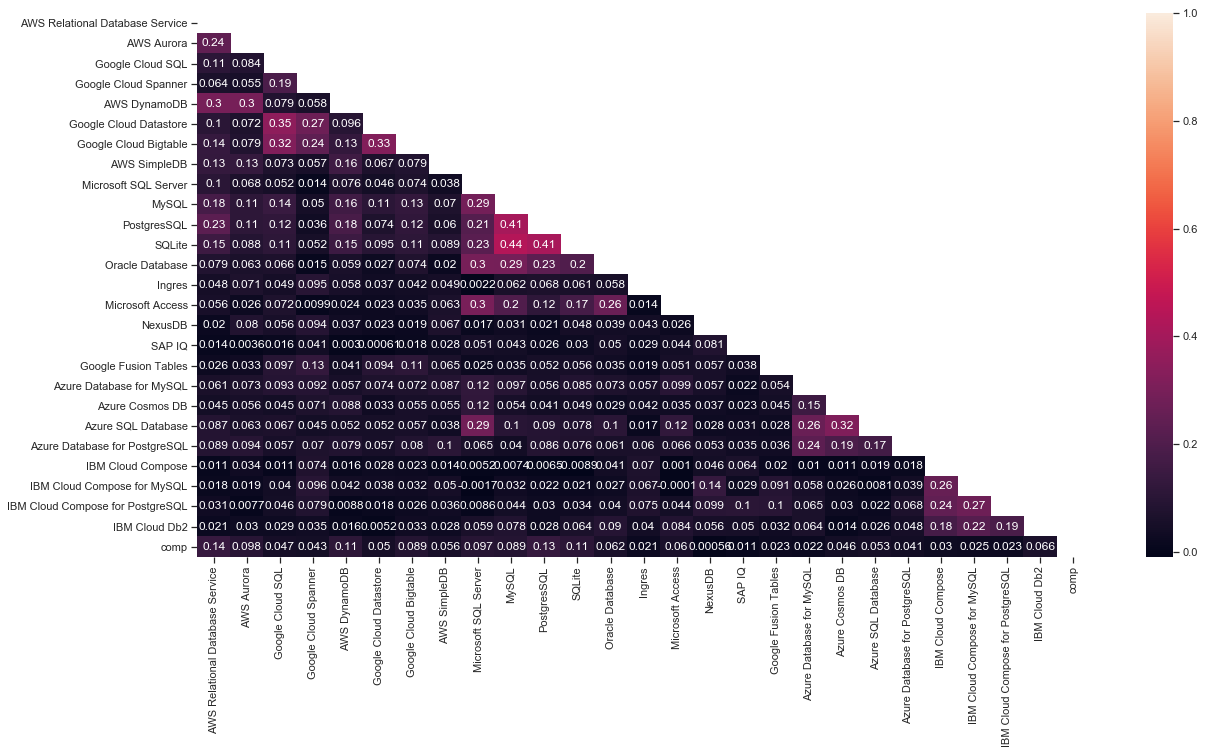

In [65]:
rcParams['figure.figsize'] = 20,10
df_comp.iloc[:,130:156].info()
df_comp.iloc[:,130:156].describe(include='all')
get_corr(130, 156)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 23 columns):
AWS Elastic MapReduce            9774 non-null int64
AWS Batch                        9774 non-null int64
Google Cloud Dataproc            9774 non-null int64
Google Cloud Dataflow            9774 non-null int64
Google Cloud Dataprep            9774 non-null int64
AWS Kinesis                      9774 non-null int64
Google Cloud Pub/Sub             9774 non-null int64
AWS Athena                       9774 non-null int64
AWS Redshift                     9774 non-null int64
Google BigQuery                  9774 non-null int64
Teradata                         9774 non-null int64
Microsoft Analysis Services      9774 non-null int64
Oracle Exadata                   9774 non-null int64
Oracle Warehouse Builder         9774 non-null int64
SAP IQ                           9774 non-null int64
Snowflake                        9774 non-null int64
Databricks                       9774 non-nu

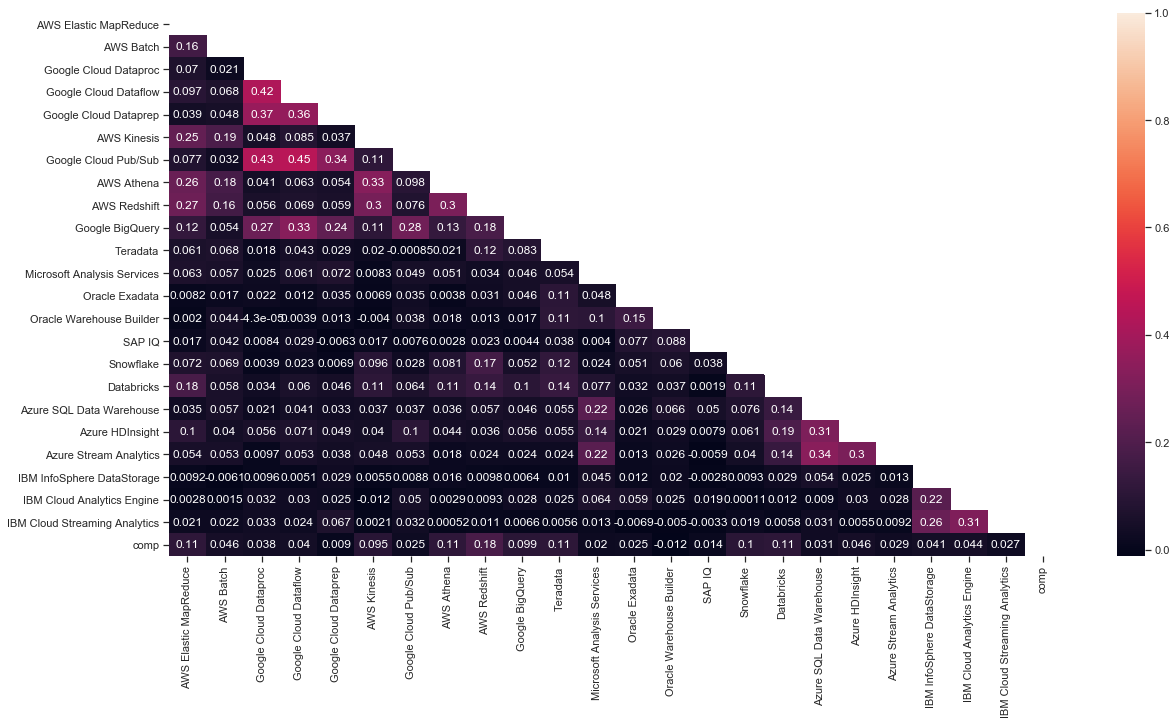

In [66]:
df_comp.iloc[:,156:179].info()
df_comp.iloc[:,156:179].describe(include='all')
get_corr(156, 179)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9774 entries, 2 to 23856
Data columns (total 11 columns):
Audio Data          9774 non-null int64
Categorical Data    9774 non-null int64
Genetic Data        9774 non-null int64
Geospatial Data     9774 non-null int64
Image Data          9774 non-null int64
Numerical Data      9774 non-null int64
Sensor Data         9774 non-null int64
Tabular Data        9774 non-null int64
Text Data           9774 non-null int64
Time Series Data    9774 non-null int64
Video Data          9774 non-null int64
dtypes: int64(11)
memory usage: 916.3 KB


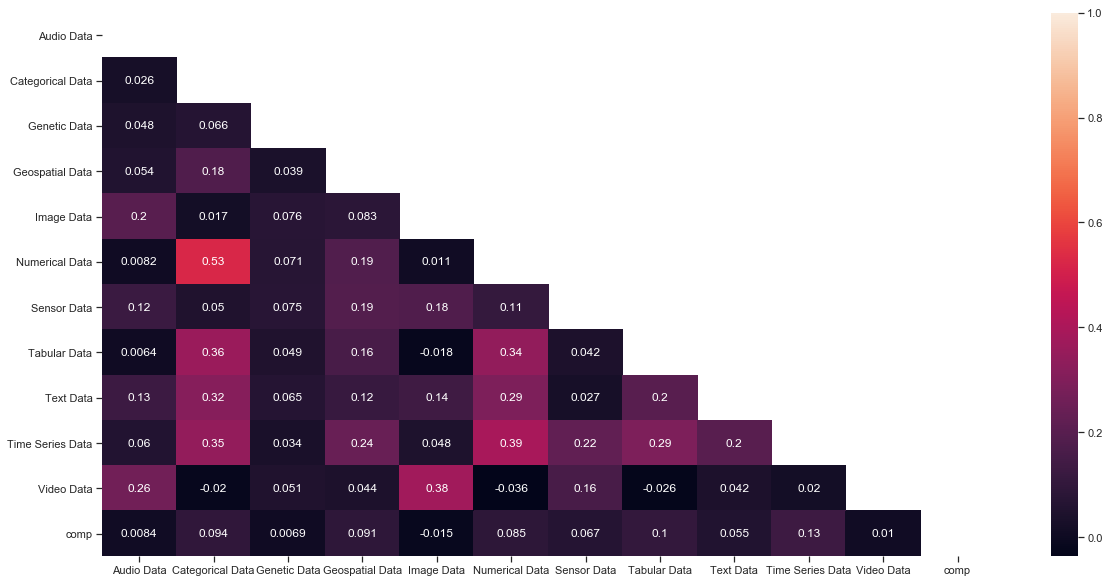

In [67]:
df_comp.iloc[:,179:190].info()
df_comp.iloc[:,179:190].describe(include='all')
get_corr(179, 190)

In [68]:
# Create correlation matrix
correl = df_comp.corr().abs()

# Select upper triangle of correlation matrix
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [69]:
to_drop

['MATLAB',
 'Domino Datalab',
 'MATLAB',
 'AWS Batch',
 'Domino Datalab',
 'SAP IQ',
 'AWS Batch',
 'SAP IQ']

In [70]:
del ren_col['Q16_Part_9']
del ren_col['Q14_Part_4']
del ren_col['Q27_Part_8']
del ren_col['Q29_Part_17']
df_comp.drop(to_drop, axis=1, inplace=True)

In [260]:
df_comp['comp']

2          5000.0
4          5000.0
6         15000.0
7          5000.0
9         25000.0
11       137500.0
14        15000.0
15        35000.0
16        55000.0
17         5000.0
18       112500.0
19        35000.0
23         5000.0
24        75000.0
27        85000.0
29        15000.0
32       112500.0
34        65000.0
35        95000.0
37        35000.0
38        85000.0
39        15000.0
41        45000.0
42         5000.0
44        15000.0
46         5000.0
50        75000.0
51         5000.0
53        25000.0
54        75000.0
           ...   
23746    175000.0
23750      5000.0
23751     85000.0
23752      5000.0
23757     45000.0
23759     15000.0
23760     15000.0
23762     15000.0
23777      5000.0
23781      5000.0
23782     15000.0
23786     25000.0
23790     15000.0
23794     25000.0
23796      5000.0
23798     95000.0
23799     15000.0
23800     25000.0
23809     25000.0
23812      5000.0
23814     15000.0
23820      5000.0
23822      5000.0
23823     75000.0
23827     

In [97]:
from sklearn import preprocessing

df_pre = df_comp[['comp']]

scaled_df = preprocessing.scale(df_pre)  

#reconstruct a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_df,    
                           index=df_pre.index,
                           columns=df_pre.columns)


In [98]:
df = df_comp.drop(['comp'], axis=1)

In [99]:
res_df = df.merge(scaled_df, how='left', left_index=True, right_index=True) 


In [ ]:
df_comp

In [98]:
df = df_comp.drop(['comp'], axis=1)

In [99]:
res_df = df.merge(scaled_df, how='left', left_index=True, right_index=True) 


In [107]:
X = df.values
y = scaled_df.values

In [108]:
import statsmodels.api as sm
# create a model with features
multi_model = sm.OLS(y,X)
fitted_multi_model = multi_model.fit()

# print the coefficients
print(fitted_multi_model.params)

[ 4.94050957e-02 -2.54621250e-02 -2.22612857e-02 -3.79210666e-02
 -9.92194550e-02 -5.66616805e-02 -6.70376498e-02 -6.56683760e-02
 -1.57135063e-02  1.65440606e-02  6.06448543e-02 -1.52730272e-02
 -4.70712574e-02 -3.17842859e-02 -5.48506913e-02  3.64281199e-02
 -5.75375243e-02 -3.77446596e-02 -3.54762268e-02 -1.78675760e-02
 -3.09248310e-03  2.54666837e-02  2.40340201e-02 -4.29378840e-02
 -6.91708623e-02  3.86498067e-02 -4.40062082e-02  7.70753560e-03
  2.14686554e-02  3.10888974e-02 -2.66999537e-03 -1.38945327e-02
  4.46727217e-02  2.70031986e-02 -3.84740981e-02  3.75409126e-02
  1.10630252e-01 -8.18305596e-02  8.22513692e-02 -4.22903106e-03
 -7.85657521e-03 -2.17331233e-02  2.79684670e-02 -2.79326846e-02
  3.87428482e-02  3.83066838e-02  8.75846810e-02  8.97295399e-02
 -1.71910716e-02  3.32020283e-02  2.31109858e-02  8.31248709e-02
  1.02825268e-06  1.15091420e-02  5.18708468e-02  3.40037517e-02
 -8.12761847e-03 -6.16559182e-03 -3.88937650e-02  4.86661691e-02
  2.45990791e-02  4.11211

In [109]:
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     34.34
Date:                Mon, 21 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:50:04   Log-Likelihood:                -10459.
No. Observations:                9774   AIC:                         2.148e+04
Df Residuals:                    9494   BIC:                         2.349e+04
Df Model:                         279                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0494      0.023      2.173      0.030       0.005       0.094
x2            -0.0255      0.023     -1.095      0.274      -0.071       0.020
x3            -0.0223      0.018     -1.259      0.208      -0.057       0.012
x4            -0.0379      0.020     -1.942      0.052      -0.076       0.000
x5            -0.0992      0.088     -1.126      0.260      -0.272       0.073
x6            -0.0567      0.020     -2.770      0.006      -0.097      -0.017
x7            -0.0670      0.021     -3.133      0.002      -0.109      -0.025
x8            -0.0657      0.017     -3.811      0.000      -0.099      -0.032
x9            -0.0157      0.018     -0.882      0.378      -0.051       0.019
x10            0.0165      0.020      0.816      0.414      -0.023       0.056
x11            0.0606      0.023      2.616      0.009       0.015       0.106
x12           -0.0153      0.018     -0.827      0.408      -0.051       0.021
x13           -0.0471      0.018     -2.658      0.008      -0.082      -0.012
x14           -0.0318      0.022     -1.440      0.150      -0.075       0.011
x15           -0.0549      0.034     -1.601      0.109      -0.122       0.012
x16            0.0364      0.034      1.075      0.282      -0.030       0.103
x17           -0.0575      0.050     -1.150      0.250      -0.156       0.041
x18           -0.0377      0.056     -0.674      0.501      -0.148       0.072
x19           -0.0355      0.093     -0.383      0.702      -0.217       0.146
x20           -0.0179      0.018     -0.985      0.325      -0.053       0.018
x21           -0.0031      0.024     -0.131      0.895      -0.049       0.043
x22            0.0255      0.022      1.178      0.239      -0.017       0.068
x23            0.0240      0.024      0.983      0.325      -0.024       0.072
x24           -0.0429      0.039     -1.109      0.268      -0.119       0.033
x25           -0.0692      0.059     -1.174      0.240      -0.185       0.046
x26            0.0386      0.028      1.368      0.171      -0.017       0.094
x27           -0.0440      0.025     -1.789      0.074      -0.092       0.004
x28            0.0077      0.018      0.432      0.666      -0.027       0.043
x29            0.0215      0.023      0.954      0.340      -0.023       0.066
x30            0.0311      0.023      1.353      0.176      -0.014       0.076
x31           -0.0027      0.024     -0.111      0.912      -0.050       0.045
x32           -0.0139      0.033     -0.422      0.673      -0.078       0.051
x33            0.0447      0.023      1.947      0.052      -0.000       0.090
x34            0.0270      0.037      0.734      0.463      -0.045       0.099
x35           -0.0385      0.073     -0.529      0.597      -0.181       0.104
x36            0.0375      0.053      0.713      0.476      -0.066       0.141
x3

In [133]:
 A = np.identity(len(fitted_multi_model.params))

In [140]:
f = fitted_multi_model.t_test(A)

In [142]:
frame_p = f.summary_frame()

In [143]:
frame_p.columns

Index(['coef', 'std err', 't', 'P>|t|', 'Conf. Int. Low', 'Conf. Int. Upp.'], dtype='object')

 P-value that the null-hypothesis that the coefficient = 0 is true. If it is less than the confidence level, often 0.05, it indicates that there is a statistically significant relationship between the term and the response.

In [147]:
#dropping not significant terms
mask_sign = frame_p['P>|t|'].map(lambda x: x < 0.05)

In [149]:
mask_sign

c0       True
c1      False
c2      False
c3      False
c4      False
c5       True
c6       True
c7       True
c8      False
c9      False
c10      True
c11     False
c12      True
c13     False
c14     False
c15     False
c16     False
c17     False
c18     False
c19     False
c20     False
c21     False
c22     False
c23     False
c24     False
c25     False
c26     False
c27     False
c28     False
c29     False
        ...  
c251     True
c252     True
c253    False
c254    False
c255    False
c256     True
c257    False
c258    False
c259     True
c260     True
c261     True
c262     True
c263     True
c264     True
c265    False
c266    False
c267    False
c268    False
c269    False
c270    False
c271    False
c272    False
c273    False
c274    False
c275    False
c276     True
c277    False
c278    False
c279    False
c280    False
Name: P>|t|, Length: 281, dtype: bool

In [309]:
list_ = list(df_comp.columns)

In [310]:
list_.remove('comp')

In [311]:
len(list_)

281

In [312]:
list_false = list(zip(mask_sign,list_))

In [313]:
df_false = pd.DataFrame(list_false, columns=['Sign','Col']) 

In [314]:
df_false = df_false[df_false['Sign'] == False]

In [315]:
df_false

,Sign,Col
1,False,RStudio
2,False,PyCharm
3,False,Visual Studio Code
4,False,nteract
8,False,Sublime Text
9,False,Vim
11,False,Spyder
13,False,Google Colab
14,False,Azure Notebook
15,False,Google Cloud Datalab


In [316]:
col_drop = df_false['Col'].values

In [317]:
len(col_drop)

185

In [318]:
df_fit = df_comp.drop(col_drop, axis=1)

In [319]:
df_fit.shape

(9774, 97)

In [228]:
df_pre = df_fit[['comp']]

scaled_df = preprocessing.scale(df_pre)  

#reconstruct a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_df,    
                           index=df_pre.index,
                           columns=df_pre.columns)

In [229]:
df = df_fit.drop(['comp'], axis=1)

In [234]:
res_df = df.merge(scaled_df, how='left', left_index=True, right_index=True) 

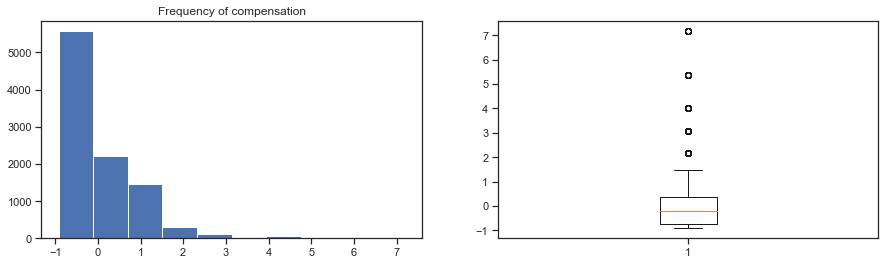

In [261]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title('Frequency of compensation')
ax[0].hist(res_df['comp'], bins=10)
ax[1].boxplot(res_df['comp'])
plt.show()

In [235]:
Salaries_Train,Salaries_Test = train_test_split(res_df,test_size=0.33, random_state=13)
print('Train Shape:', Salaries_Train.shape)
print('Test Shape:', Salaries_Test.shape)

Train Shape: (6548, 97)
Test Shape: (3226, 97)


## Model Implementation


In [262]:
def run_kfold(model):
    
    X = Salaries_X
    Y = Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

In [263]:
Salaries_Y = Salaries_Train['comp']
Salaries_X = Salaries_Train.drop(['comp'], axis=1)

Salaries_Y_Test = Salaries_Test['comp']
Salaries_X_Test = Salaries_Test.drop(['comp'], axis=1)

## A Linear Regression

In [264]:
model_lr = linear_model.LinearRegression()
run_kfold (model_lr)

predictions = model_lr.predict(Salaries_X_Test)
Test_Score = r2_score(Salaries_Y_Test, predictions)

print ("------------------\n Test Score: " + str(Test_Score))

Fold 1 accuracy: 0.5294501689792845
Fold 2 accuracy: 0.3580542315499199
Fold 3 accuracy: 0.4669966233693441
Fold 4 accuracy: 0.46388393940342587
Fold 5 accuracy: 0.4144049698397182
Fold 6 accuracy: 0.4489937125315354
Fold 7 accuracy: 0.42593378157983175
Fold 8 accuracy: 0.45762824352874876
Fold 9 accuracy: 0.48153912242762376
Fold 10 accuracy: 0.4417495038375423
Mean r2: 0.4488634297046975
Standard Deviation: 0.04266528264416091
------------------
 Test Score: 0.4173827153757096


In [265]:
mean_absolute_error(Salaries_Y_Test,predictions)

0.465082482425042

Look at features and coefficients

In [266]:
sorted(list(zip(model_lr.coef_, Salaries_X)))

[(-0.6276766258036627, 'country<>Vietnam'),
 (-0.625761923338279, 'country<>Egypt'),
 (-0.5264908183641555, 'country<>Pakistan'),
 (-0.5091931408111535, 'title<>Marketing Analyst'),
 (-0.5068099709662137, 'country<>Turkey'),
 (-0.5054030396899785, 'country<>Philippines'),
 (-0.5018914021223, 'country<>Iran'),
 (-0.5009349065852864, 'country<>Indonesia'),
 (-0.4790283228549344, 'country<>Greece'),
 (-0.4754378510837027, 'country<>Nigeria'),
 (-0.4648388824989237, 'country<>Peru'),
 (-0.4556689485435796, 'title<>Data Analyst'),
 (-0.4392090348671449, 'country<>Belarus'),
 (-0.43323203870238286, 'country<>Morocco'),
 (-0.42261790633811985, 'country<>Bangladesh'),
 (-0.422234477003508, 'country<>Romania'),
 (-0.4218008480755658, 'country<>India'),
 (-0.42002901055686037, 'country<>Colombia'),
 (-0.40869223762047274, 'country<>Ukraine'),
 (-0.39986520150411736, 'title<>Business Analyst'),
 (-0.39270127467315513, 'country<>Russia'),
 (-0.3843901330358408, 'country<>Malaysia'),
 (-0.360600918

In [241]:
sorted(list(zip(model_lr.coef_, Salaries_X)),reverse=True)

[(1.1217270733593878, 'ML using<>20+'),
 (1.0668685544132444, 'country<>United States'),
 (0.9381253575413565, 'country<>Switzerland'),
 (0.8024101216324943, 'country<>Israel'),
 (0.7023316403272726, 'country<>Australia'),
 (0.596376582903489, 'IBM Cloud Compose'),
 (0.5118096554064857, 'country<>Canada'),
 (0.5100827019987293, 'country<>Denmark'),
 (0.4233372999244311, 'IBM Cloud Analytics Engine'),
 (0.36977236330140584, 'country<>Norway'),
 (0.36494870375830085, 'country<>United Kingdom'),
 (0.35990765910930633, 'Snowflake'),
 (0.33817425351666036, 'country<>Hong Kong'),
 (0.3147994587711343, 'country<>Germany'),
 (0.30734984321607905, 'DataRobot'),
 (0.27423515186021774, 'country<>Ireland'),
 (0.2562724114347597, 'Mxnet'),
 (0.23678571083285074, 'country<>Netherlands'),
 (0.2349406538704506, 'country<>Singapore'),
 (0.21772839515203135, 'Amazon Transcribe'),
 (0.21710063951398698, 'country<>Japan'),
 (0.21607398326827873, 'Teradata'),
 (0.20160140882357347, 'country<>Sweden'),
 (0.

## Feature Selection

In [267]:
rfe = RFE(model_lr)
fit = rfe.fit(Salaries_X, Salaries_Y) 

In [273]:
sorted(list(zip(fit.ranking_,Salaries_X)))

[(1, 'AWS Redshift'),
 (1, 'Amazon Transcribe'),
 (1, 'DataRobot'),
 (1, 'IBM Cloud Analytics Engine'),
 (1, 'IBM Cloud Compose'),
 (1, 'ML using<>20+'),
 (1, 'Mxnet'),
 (1, 'Prophet'),
 (1, 'Snowflake'),
 (1, 'country<>Australia'),
 (1, 'country<>Bangladesh'),
 (1, 'country<>Belarus'),
 (1, 'country<>Canada'),
 (1, 'country<>Colombia'),
 (1, 'country<>Denmark'),
 (1, 'country<>Egypt'),
 (1, 'country<>Germany'),
 (1, 'country<>Greece'),
 (1, 'country<>Hong Kong'),
 (1, 'country<>India'),
 (1, 'country<>Indonesia'),
 (1, 'country<>Iran'),
 (1, 'country<>Ireland'),
 (1, 'country<>Israel'),
 (1, 'country<>Japan'),
 (1, 'country<>Malaysia'),
 (1, 'country<>Mexico'),
 (1, 'country<>Morocco'),
 (1, 'country<>Netherlands'),
 (1, 'country<>Nigeria'),
 (1, 'country<>Norway'),
 (1, 'country<>Other'),
 (1, 'country<>Pakistan'),
 (1, 'country<>Peru'),
 (1, 'country<>Philippines'),
 (1, 'country<>Portugal'),
 (1, 'country<>Romania'),
 (1, 'country<>Russia'),
 (1, 'country<>Singapore'),
 (1, 'countr

In [274]:
print(rfe.support_)

[False False False False False False False False False  True  True False
 False False False  True  True False False False False  True False  True
 False  True  True False False False False  True  True  True False  True
 False  True False  True  True  True  True  True False  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True False  True  True False  True
  True  True  True  True False False  True False False False  True False
 False False False False False False False False False False False  True]


## Neural Network

In [300]:
#for traindata better but for test worst...overfitting.

In [283]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8,4), random_state=1, max_iter=1000)
clf.fit(Salaries_X, Salaries_Y)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 8, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [284]:
clf.score(Salaries_X, Salaries_Y)

0.5739432466295

In [285]:
clf.score(Salaries_X_Test, Salaries_Y_Test)

0.2921885130389902

In [ ]:
# does not show not significant improvements 

# PCA 

In [296]:
from sklearn.decomposition import PCA
pca = PCA(n_components=96)
pca.fit(Salaries_X)
PCA_X = pca.transform(Salaries_X)
PCA_X_Test = pca.transform(Salaries_X_Test)
model_lr_pca = linear_model.LinearRegression()
model_lr_pca.fit(PCA_X,Salaries_Y)

predictions_pca_train = model_lr_pca.predict(PCA_X)
predictions_pca_test = model_lr_pca.predict(PCA_X_Test)

print ("Train r2 Score")

print (r2_score(Salaries_Y, predictions_pca_train))  

print ("Test r2 Score")

print (r2_score(Salaries_Y_Test,predictions_pca_test))

Train r2 Score
0.46462822603224074
Test r2 Score
0.4189104938895065


In [344]:
multipleChoice_q['Q30_Part_9'][0] #'AWS Redshift'

'Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - AWS Redshift'

In [345]:
multipleChoice_q['Q28_Part_1'][0] #Amazon Transcribe

'Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Amazon Transcribe'

In [346]:
multipleChoice_q['Q28_Part_16'][0] #DataRobot

'Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - DataRobot'

In [347]:
multipleChoice_q['Q30_Part_22'][0] #IBM Cloud Analytics Engine

'Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - IBM Cloud Analytics Engine'

In [348]:
multipleChoice_q['Q29_Part_23'][0] #IBM Cloud Compose

'Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - IBM Cloud Compose'

Years of using machine learning methods ? 20+


In [349]:
multipleChoice_q['Q19_Part_8'][0] #Mxnet

'What machine learning frameworks have you used in the past 5 years? (Select all that apply) - Selected Choice - Mxnet'

In [350]:
multipleChoice_q['Q19_Part_12'][0] #Prophet

'What machine learning frameworks have you used in the past 5 years? (Select all that apply) - Selected Choice - Prophet'

In [351]:
multipleChoice_q['Q30_Part_16'][0] #Snowflake

'Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Snowflake'

In [355]:
multipleChoice_q['Q27_Part_1'][0] #AWS Elastic Compute Cloud (EC2)

'Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice - AWS Elastic Compute Cloud (EC2)'

## The compensation  tends to raise when respondents use 
**big data and analytics products**: AWS Redshift, IBM Cloud Analytics Engine, AWS Athena,  Snowflake; 
**machine learning products**: Amazon Transcribe, DataRobot, Azure Speaker Recognition API; 
**relational database products**: IBM Cloud Compose, Google Cloud Bigtable; 
**cloud computing products**: AWS Elastic Compute Cloud (EC2); 
**machine learning frameworks**: Mxnet, Prophet, Fastai

**Time Series Data** Type of Data; 
**Prog. Languages** C#/.NET, Jupyter/IPython 

and when they have the expertise of using ML methods many years